In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from transformers import ViTModel
from sklearn.model_selection import KFold
from torchvision import transforms
from transformers.models.vit.modeling_vit import ViTEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
image_size = (224, 224)
batch_size = 16
epochs = 30
learning_rate = 0.0001
gamma = 0.5

dataset_path = "/kaggle/input/monkeypoxskinimagedataset/Monkeypox Skin Image Dataset"

import torchvision.transforms as transforms
import random
import torch

In [22]:
def strong_augmentations(prob=0.5):
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=prob),  # Random rotation
        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=prob),  # Random translation
        transforms.RandomHorizontalFlip(p=0.5),  # Horizontal Flip
        transforms.RandomApply([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0))], p=prob),  # Random Crop
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=prob),  # Color Jitter
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=prob),  # Slight Blur
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

# Use Stronger Augmentations
transform = strong_augmentations()

In [23]:
# Apply MixUp and CutMix in the DataLoader
def mixup_data(x, y, alpha=1.0):
    """MixUp Regularization"""
    if alpha > 0:
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def filter_dataset():
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
# Filter for binary classification (Monkeypox vs. Non-Monkeypox)
monkeypox_class = [cls for cls in dataset.classes if "monkeypox" in cls.lower()]
non_monkeypox_class = [cls for cls in dataset.classes if cls not in monkeypox_class]
binary_classes = monkeypox_class + non_monkeypox_class
class_to_idx = {cls: idx for idx, cls in enumerate(binary_classes)}
dataset.class_to_idx = class_to_idx
dataset.samples = [(path, class_to_idx[cls]) for path, cls in dataset.samples if cls in binary_classes]

    return dataset

dataset = filter_dataset()

In [24]:
# Broad Attention Mechanism
class BroadAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(BroadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, queries, keys, values):
        queries = torch.cat(queries, dim=1)
        keys = torch.cat(keys, dim=1)
        values = torch.cat(values, dim=1)
        attention_output, _ = self.attention(queries, keys, values)
        pooled_output = self.pool(attention_output.permute(0, 2, 1)).squeeze(-1)
        return pooled_output


In [26]:
# MVIT-Integrated B2VIT Model
class B2MVITNet(nn.Module):
    def __init__(self, vit_model_name, num_classes, gamma=0.5):
        super(B2MVITNet, self).__init__()
        self.vit = ViTModel.from_pretrained(vit_model_name, output_attentions=True)
        self.hidden_size = self.vit.config.hidden_size
        self.num_layers = len(self.vit.encoder.layer)
        self.gamma = gamma

        # Multiscale Fusion
        self.mvit_encoder = ViTEncoder(self.vit.config)
        self.mvit_attention = nn.MultiheadAttention(embed_dim=self.hidden_size, num_heads=8)
        
        # Broad Attention Mechanism
        self.broad_attention = BroadAttention(hidden_size=self.hidden_size, num_layers=self.num_layers)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        deep_features = hidden_states[-1][:, 0, :]
        queries = [layer[:, 0, :].unsqueeze(1) for layer in hidden_states]
        broad_features = self.broad_attention(queries, queries, queries)

        # MVIT Feature Extraction
        mvit_outputs = self.mvit_encoder(hidden_states[-1])
        mvit_features = mvit_outputs.last_hidden_state[:, 0, :]

        # Combine Features
        combined_features = torch.cat((deep_features, self.gamma * broad_features + mvit_features), dim=1)
        logits = self.classifier(combined_features)
        return logits

kf = KFold(n_splits=5, shuffle=True, random_state=42)
class_names = dataset.classes
all_preds, all_targets = [], []
history = {
    "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [],
    "train_precision": [], "train_recall": [], "train_f1": [],
    "val_precision": [], "val_recall": [], "val_f1": []
}

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"\n Starting Fold {fold + 1}...")

    train_subset, val_subset = Subset(dataset, train_indices), Subset(dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = B2MVITNet("google/vit-base-patch16-224-in21k", num_classes=4, gamma=gamma).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_preds.extend((outputs > 0.5).long()(outputs, dim=1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_precision = precision_score(train_targets, train_preds, average='weighted')
        train_recall = recall_score(train_targets, train_preds, average='weighted')
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_precision"].append(train_precision)
        history["train_recall"].append(train_recall)
        history["train_f1"].append(train_f1)

        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_preds.extend((outputs > 0.5).long()(outputs, dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_precision = precision_score(val_targets, val_preds, average='weighted')
        val_recall = recall_score(val_targets, val_preds, average='weighted')
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_precision"].append(val_precision)
        history["val_recall"].append(val_recall)
        history["val_f1"].append(val_f1)

        
        all_preds.extend(val_preds)
        all_targets.extend(val_targets)

        #  Print Training & Validation Metrics for Each Epoch
        print(f" Epoch [{epoch + 1}/{epochs}] - Fold {fold + 1}")
        print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f}")
        print(f" Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")

    print(f"\n Fold {fold + 1} complete!\n" + "="*50)

# Debugging Output
print(f"\nTotal predictions collected: {len(all_preds)}")
print(f"Total targets collected: {len(all_targets)}")




 Starting Fold 1...
 Epoch [1/30] - Fold 1
 Train Loss: 0.7693 | Train Acc: 0.7646 | Precision: 0.7654 | Recall: 0.7646 | F1: 0.7649
 Val Loss:   0.3624 | Val Acc:   0.9026 | Precision: 0.9304 | Recall: 0.9026 | F1: 0.9067
 Epoch [2/30] - Fold 1
 Train Loss: 0.3282 | Train Acc: 0.8945 | Precision: 0.8948 | Recall: 0.8945 | F1: 0.8946
 Val Loss:   0.3336 | Val Acc:   0.8961 | Precision: 0.8945 | Recall: 0.8961 | F1: 0.8938
 Epoch [3/30] - Fold 1
 Train Loss: 0.2597 | Train Acc: 0.9172 | Precision: 0.9181 | Recall: 0.9172 | F1: 0.9176
 Val Loss:   0.4677 | Val Acc:   0.8701 | Precision: 0.8858 | Recall: 0.8701 | F1: 0.8505
 Epoch [4/30] - Fold 1
 Train Loss: 0.2558 | Train Acc: 0.9221 | Precision: 0.9218 | Recall: 0.9221 | F1: 0.9219
 Val Loss:   0.4901 | Val Acc:   0.8961 | Precision: 0.8957 | Recall: 0.8961 | F1: 0.8938
 Epoch [5/30] - Fold 1
 Train Loss: 0.1757 | Train Acc: 0.9399 | Precision: 0.9406 | Recall: 0.9399 | F1: 0.9401
 Val Loss:   0.3948 | Val Acc:   0.8896 | Precision: 0

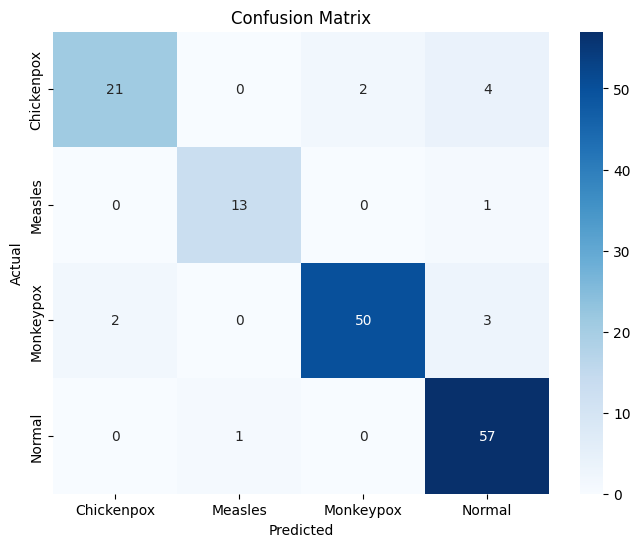

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


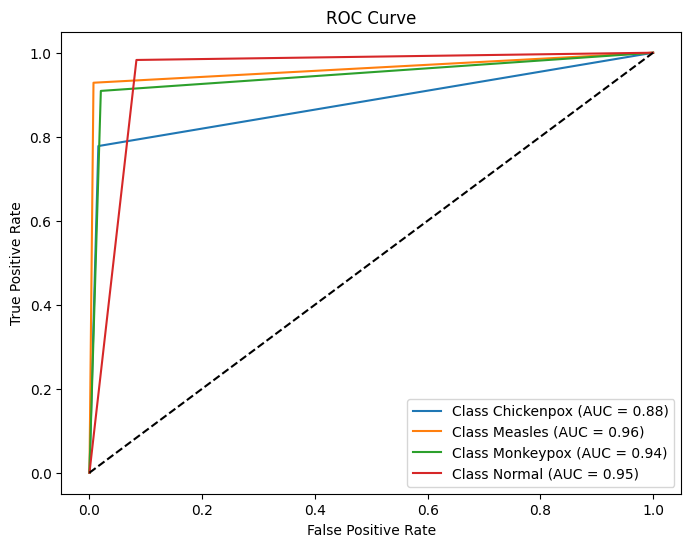

In [28]:
from sklearn.metrics import roc_curve, auc
import numpy as np

n_classes = len(class_names)
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(np.array(val_targets) == i, np.array(val_preds) == i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


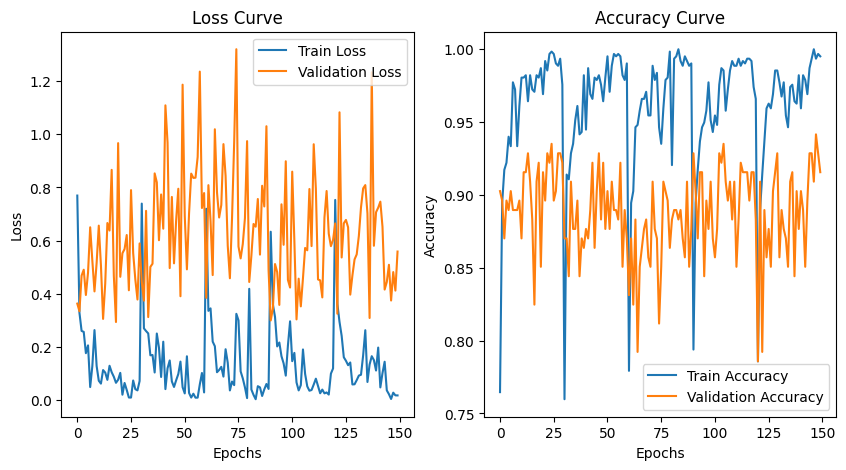

In [29]:
plt.figure(figsize=(10, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()
